In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from skimage import data, util, transform
from skimage.transform import AffineTransform
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')
rc('image', cmap='gray', interpolation='nearest')


In [2]:
%matplotlib inline

In [3]:
edge = 10
size = 128
mask = data.binary_blobs(length=size+2*edge, blob_size_fraction=0.07, volume_fraction=.25, seed=1)

crop = np.s_[edge:(edge+size),edge:(edge+size)]

image = np.random.normal(loc = .7, scale=.003, size=mask.shape)
image[np.invert(mask)] = .3

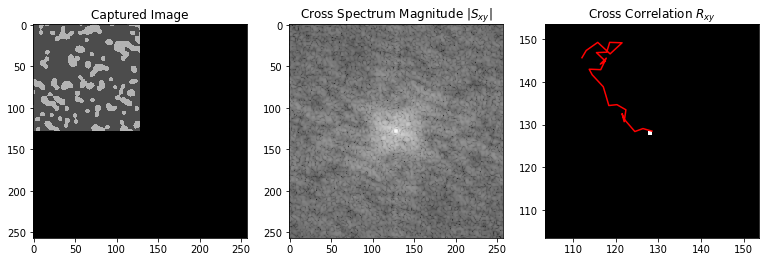

In [51]:
pad = np.zeros((2*size+1, 2*size+1), np.float32)

hann = scipy.signal.hanning(size)
window = np.zeros_like(pad)
window[:size,:size] = np.sqrt(np.outer(hann, hann))

def frequency(image):
    return np.fft.fftshift(np.log(np.abs(np.fft.fft2(window*image))))

class distort_model:
    def __init__(self, image, length=9999999):
        self.image = image
        self.length = length
        self.walk = [(0,0)]
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.walk.append(self.walk[-1] + np.random.choice(np.arange(-3,3,.1), size=2))
        xform = AffineTransform(translation = self.walk[-1])
        capture = transform.warp(image, xform)
        capture = util.random_noise(capture, var=.0001)
        
        if len(self.walk) > self.length:
            raise StopIteration()
            
        return capture[crop]
    
walklen = 25
mu_image = np.zeros_like(pad)
model = distort_model(image, walklen)
np.random.seed(10)
mu_image[:size,:size] = sum(list(model))/walklen
pad[:size,:size] = image[crop]
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(13,4))
im = ax1.imshow(pad, vmin=0, vmax=1.0, animated=True)
ax1.set_title('Captured Image')

ax2.set_title('Cross Spectrum Magnitude $|S_{xy}|$')

Sxy = np.fft.fft2(window*mu_image)*np.conjugate(np.fft.fft2(window*mu_image))
im2 = ax2.imshow(np.fft.fftshift(np.log(np.absolute(Sxy))))
Sxy = Sxy/np.absolute(Sxy)
Rxy = np.fft.ifft2(Sxy)
im3 = ax3.imshow(np.log(np.fft.fftshift(np.abs(Rxy))), vmax=0, vmin=-10)
argmax = np.unravel_index(np.fft.fftshift(np.abs(Rxy)).argmin(), Rxy.shape)
vmark = ax3.axvline(argmax[0], color='yellow')
hmark = ax3.axhline(argmax[1], color='yellow')
track, = ax3.plot([], [], color='cyan')
truth, = ax3.plot([pad.shape[0]/2 + x[0] for x in model.walk], [pad.shape[1]/2 + x[1] for x in model.walk], color='red')
plt.axis([pad.shape[0]/2-25,pad.shape[0]/2+25,pad.shape[1]/2-25,pad.shape[1]/2+25])
ax3.set_title('Cross Correlation $R_{xy}$')

capture = distort_model(image)
mu_F = np.conjugate(np.fft.fft2(window*mu_image))

def init():
    capture = distort_model(image)
    np.random.seed(10)
    return im2, vmark, hmark, track

walk_x = []
walk_y = []
truth_x = []
truth_y = []

def animate(i):
    frame = np.zeros_like(pad)
    frame[:size,:size] = window[crop]*next(capture)
    im.set_array(frame)
    
    Sxy = np.fft.fft2(frame)*mu_F
    im2.set_array(np.fft.fftshift(np.log(np.absolute(Sxy)))) 
    Sxy = Sxy/np.absolute(Sxy)
 
    Rxy = np.fft.fftshift(np.abs(np.fft.ifft2(Sxy)))
    argmax = np.unravel_index(Rxy.argmax(), Rxy.shape)
    im3.set_data(np.log(Rxy))
    vmark.set_xdata([argmax[0]])
    hmark.set_ydata([argmax[1]])
    walk_x.append(argmax[0])
    walk_y.append(argmax[1])
    track.set_data(walk_x, walk_y)
    #truth_x.append(xform.params[0,2])
    #truth_y.append(xform.params[1,2])
    # truth.set_data(truth_x, truth_y)
    return im, im2, im3, vmark, hmark, track

In [52]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=walklen, interval=150, blit=True)
anim

## fig2, ax2 = plt.subplots()
ax2.plot(walk[:,0], walk[:,1])
ax2.autoscale()